# Expectation-Maximization algorithm

In [1]:
using Distributions

## Genetics example

### Obtaining the estimate

In [2]:
θ = 0.5

x = [125, 18, 20, 34]

for i = 1:9
    num = x[1] * θ / (2 + θ) + x[4]
    dem = x[1] * θ / (2 + θ) + x[2] + x[3] + x[4]
    global θ = num / dem
    println("Iteration $i: θ = $θ")
end

Iteration 1: θ = 0.6082474226804123
Iteration 2: θ = 0.6243210503692704
Iteration 3: θ = 0.6264888790796673
Iteration 4: θ = 0.6267773223473097
Iteration 5: θ = 0.6268156321100443
Iteration 6: θ = 0.6268207190193078
Iteration 7: θ = 0.6268213944559841
Iteration 8: θ = 0.6268214841396688
Iteration 9: θ = 0.6268214960477559


### Obtaining the standard error

In [3]:
y_expected = x[1] * θ / (2 + θ)
inf_full = (y_expected + x[4]) / θ^2 + (x[2] + x[3]) / (1 - θ)^2
inf_missing = x[1] * 2 / (θ * (θ + 2)^2)
inf_observed = inf_full - inf_missing
se = sqrt(1 / inf_observed)

0.05146734934660761

In [4]:
q975 = quantile(Normal(), 0.975)
ml_ci = [θ - q975 * se, θ + q975 * se]

2-element Vector{Float64}:
 0.5259473449486638
 0.7276956471468481

## Clustering example

Karl Pearson's crab data

In [5]:
using Distributions
using CairoMakie
using StatsBase

### Simulate data

In [6]:
μ = [0.6375, 0.6565]
σ = [0.02, 0.012]
prob = [0.3, 0.7]
Y = MixtureModel(Normal.(μ, σ), prob)

MixtureModel{Distributions.Normal{Float64}}(K = 2)
components[1] (prior = 0.3000): Distributions.Normal{Float64}(μ=0.6375, σ=0.02)
components[2] (prior = 0.7000): Distributions.Normal{Float64}(μ=0.6565, σ=0.012)


In [7]:
y = rand(Y, 5000)

5000-element Vector{Float64}:
 0.6405411596690053
 0.6706357184148667
 0.6662874363892272
 0.6578959217864976
 0.641811209454691
 0.6186142320691407
 0.5970790659028948
 0.6490722944798941
 0.6505901901862776
 0.6270598583048008
 ⋮
 0.6753127786260755
 0.6681119344015469
 0.6564307208909463
 0.669925880967016
 0.6365244286170543
 0.6720374878072968
 0.6604484266891261
 0.6691936837185024
 0.6839081257953578

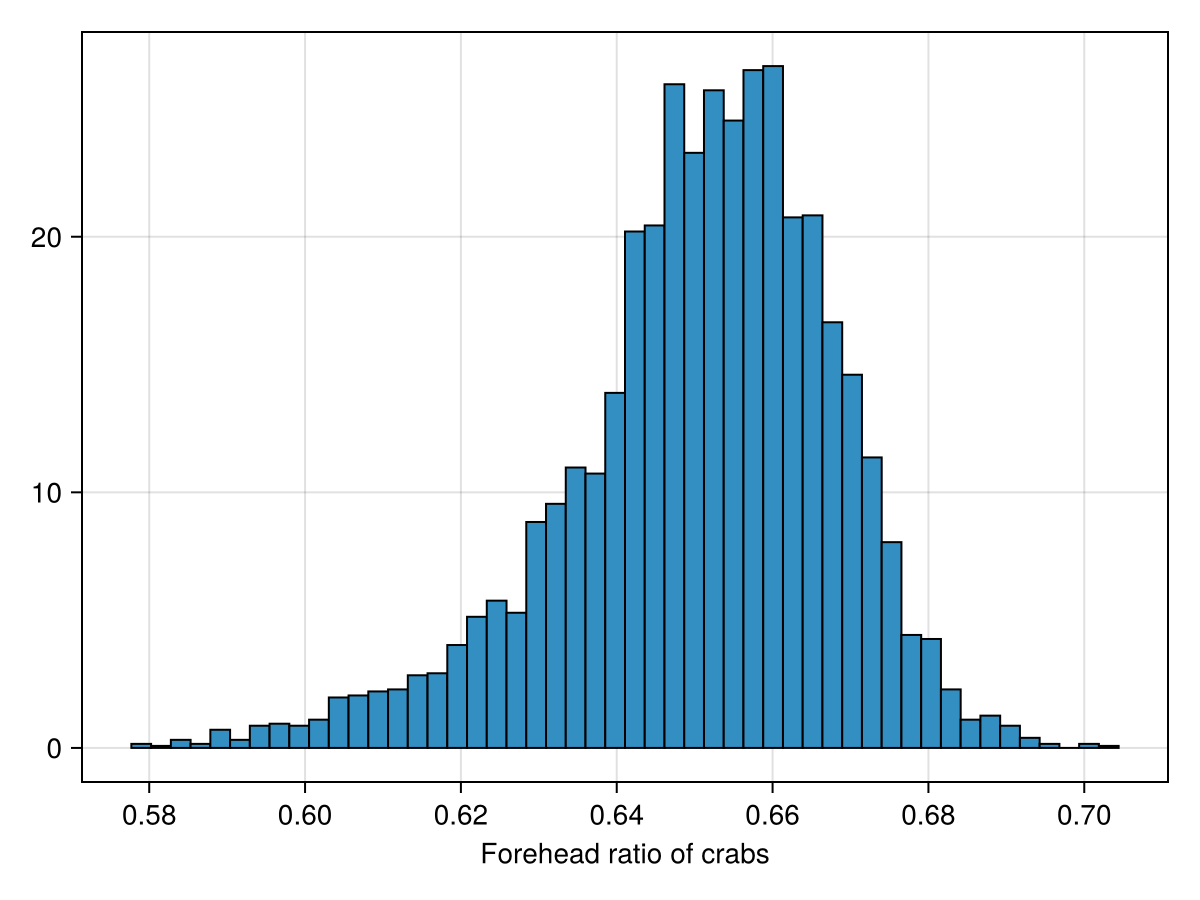

In [8]:
axis_args = (xticks = 0.54:0.02:0.74, xlabel = "Forehead ratio of crabs")
hist(y, bins = 50, strokewidth = 1, normalization = :pdf, axis = axis_args)

### EM algorithm

In [9]:
function em_mixture(y, initial; niter = 11)
    iterations = zeros(6, niter)
    θ = initial
    for i = 2:niter
        # update probabilities
        ϕ₁ = Normal(θ[2], sqrt(θ[3]))
        ϕ₂ = Normal(θ[5], sqrt(θ[6]))
        p₁ = θ[1] * pdf(ϕ₁, y) ./ (θ[1] * pdf(ϕ₁, y) + θ[4] * pdf(ϕ₂, y))
        p₂ = 2 .- p₁
        # update parameters
        θ[1] = mean(p₁)
        θ[2] = sum(y .* p₁) / sum(p₁)
        θ[3] = sum((y .- θ[2]).^2 .* p₁) / sum(p₁)
        θ[4] = 1 - θ[1]
        θ[5] = sum(y .* p₂) / sum(p₂)
        θ[6] = sum((y .- θ[5]).^2 .* p₂) / sum(p₂)
        iterations[:, i] = θ
    end
    return θ, iterations
end

θ, iters = em_mixture(y, [0.5, 0.5, 0.001, 0.5, 0.8, 0.001], niter = 1000)

([0.03202170624283502, 0.6046488793845289, 0.00010448570980831769, 0.9679782937571649, 0.6513771924978008, 0.0002681410421175004], [0.0 0.44381589633597124 … 0.032021706242835325 0.03202170624283502; 0.0 0.6365012706337873 … 0.604648879384529 0.6046488793845289; … ; 0.0 0.6546581990754561 … 0.6513771924978006 0.6513771924978008; 0.0 0.0002543894474197627 … 0.00026814104211750014 0.0002681410421175004])

### Visualize

#### Convergence

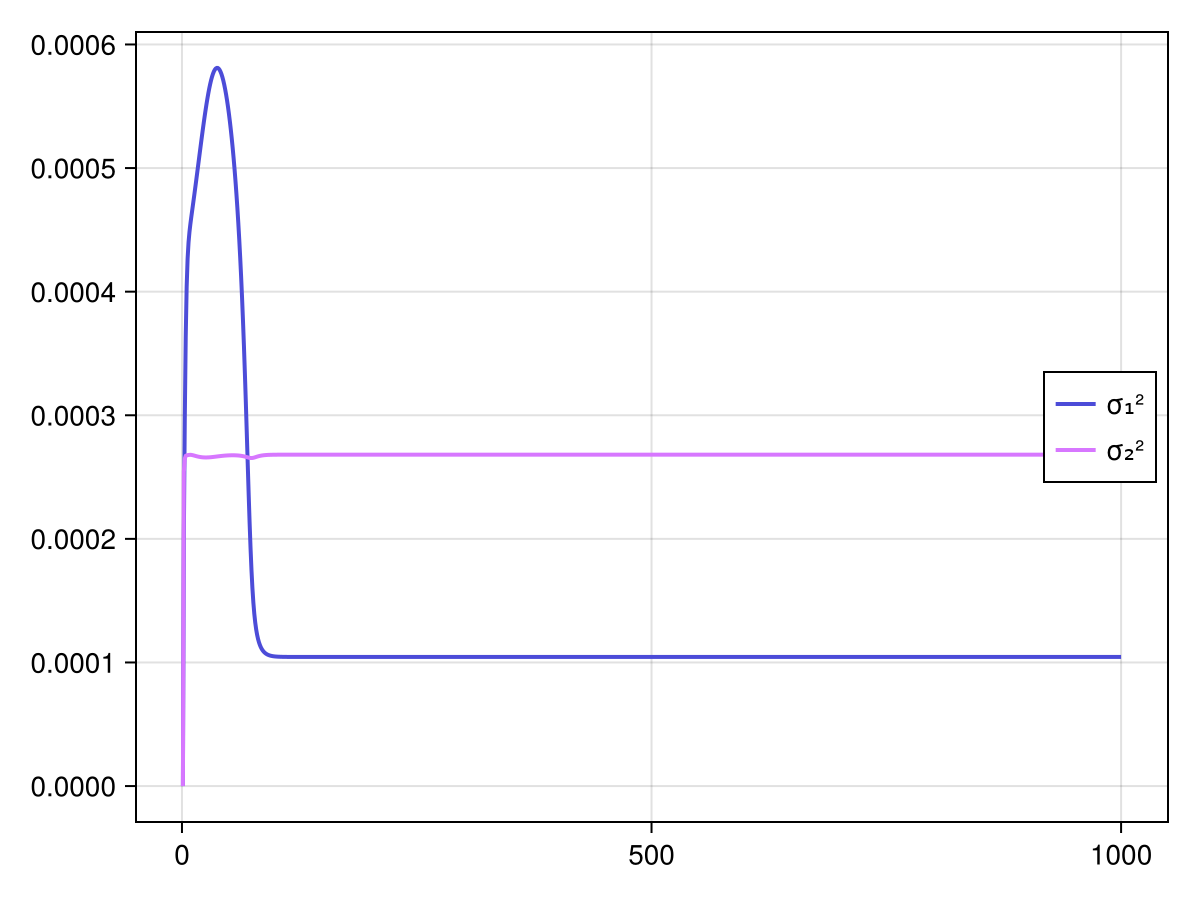

In [10]:
fig, ax = series(iters[[1, 2, 4, 5], :], labels=["π₁", "μ₁", "π₂", "μ₂"], color = :Set1)
axislegend(ax, position = :rc)
fig

fig, ax = series(iters[[3, 6], :], labels=["σ₁²", "σ₂²"])
axislegend(ax, position = :rc)
fig

#### Fitted density

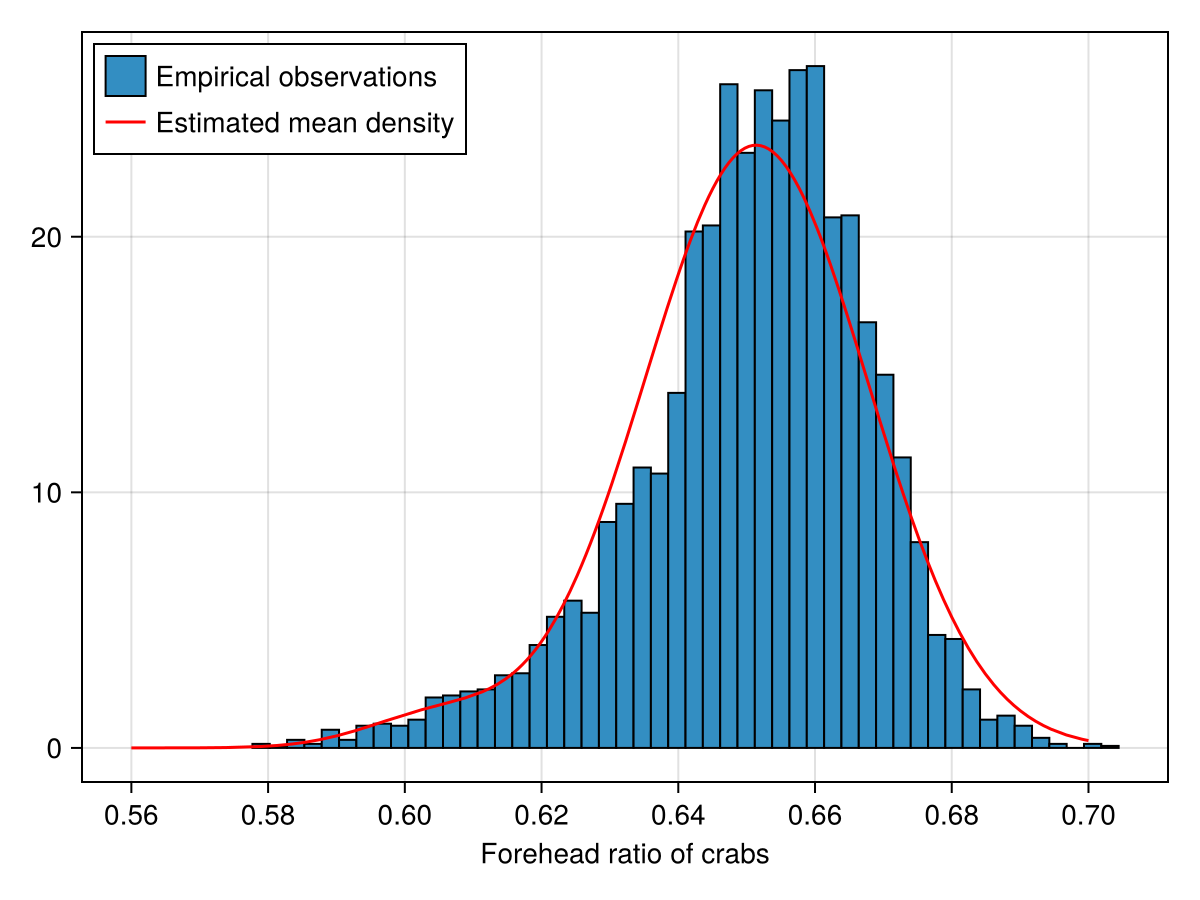

In [11]:
Yest = MixtureModel(Normal.([θ[2], θ[5]], sqrt.([θ[3], θ[6]])), [θ[1], θ[4]])
fig, ax = hist(y, bins = 50, strokewidth = 1, normalization = :pdf,
    label = "Empirical observations", axis = axis_args)
lines!(0.56..0.7, x -> pdf(Yest, x), color = :red, label = "Estimated mean density")
axislegend(ax, position = :lt)
fig

## Censored data

In [12]:
using DataFrames
using Distributions
using CairoMakie
using StatsBase

### Simulation

In [13]:
δ = 1/10
a = 25
Y = Gamma(2, 1/δ)

Distributions.Gamma{Float64}(α=2.0, θ=10.0)

In [14]:
y = rand(Y, 5000)
y = @. ifelse(y >= a, a, y)

5000-element Vector{Real}:
 25
 25
 14.926295799739801
 10.873778142631163
  3.9869152732118343
 25
 25
  4.996872383340089
  8.461867628717718
 15.9835580786361
  ⋮
 24.641394377045422
  2.269364345857247
 25
 15.510290590277998
 11.084884844203108
 10.37157654259007
  4.125647911608859
 25
  8.803534710552812

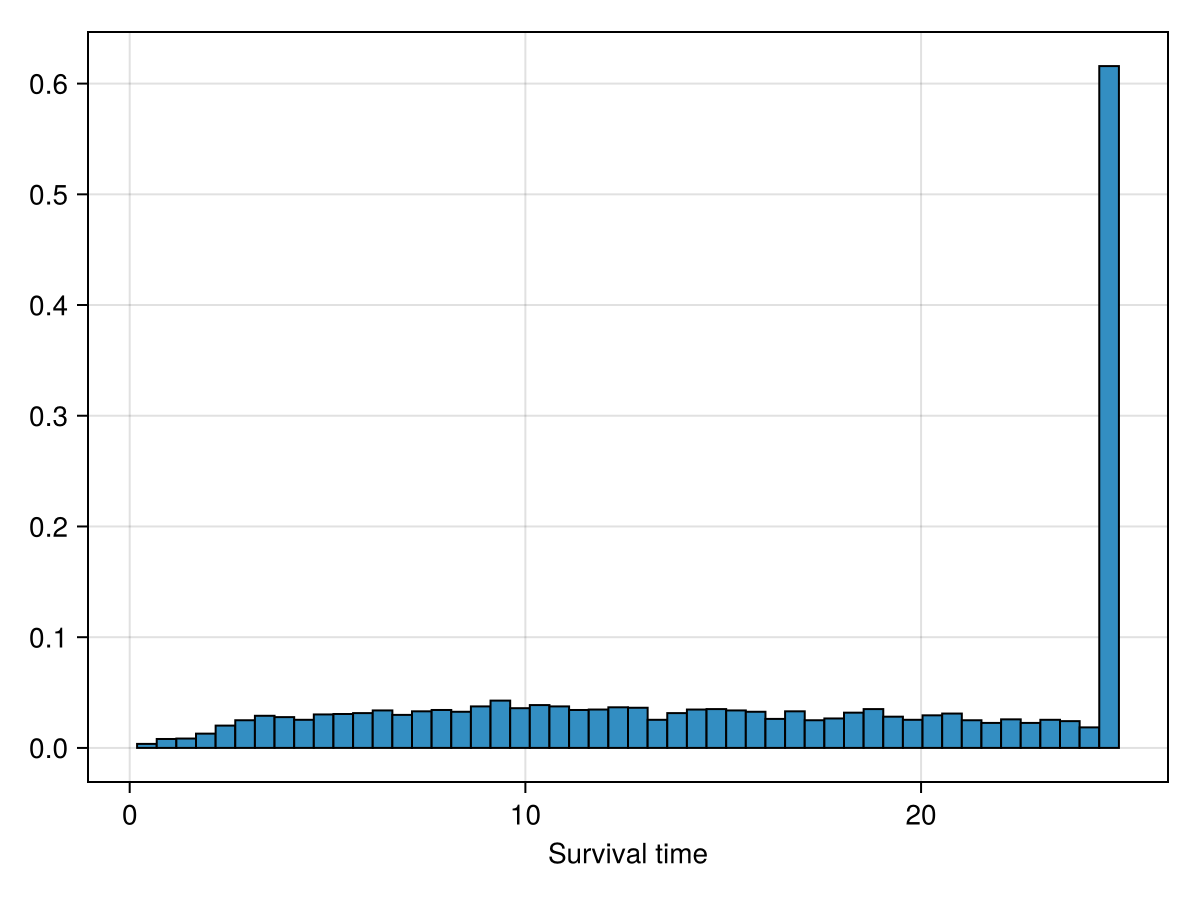

In [15]:
axis_args = (;xlabel = "Survival time")
hist(y, bins = 50, strokewidth = 1, normalization = :pdf, axis = axis_args)

### Inference

In [16]:
function em_censored(y, initial, a, n; niter = 10)
    m = length(y)
    iterations = zeros(niter)
    θ = initial
    for i = 1:niter
        # update esperanza truncada
        z_mean = (2 + 2*a*θ + a^2*θ^2) / (θ * (1 + θ*a))
        # update parameters
        θ = 2 * n / (sum(y) + (n-m) * z_mean)
        iterations[i] = θ
    end
    return θ, iterations
end

y2 = filter(x -> x < a, y)
θ, iters = em_censored(y2, 10, a, length(y); niter = 50)

(0.09830399822661577, [0.12128382638474272, 0.10251992190013624, 0.09920344560911906, 0.09850153175556808, 0.09834765097157419, 0.09831365823485871, 0.09830613655803587, 0.09830447159762642, 0.09830410302021214, 0.09830402142561545  …  0.09830399822661577, 0.09830399822661577, 0.09830399822661577, 0.09830399822661577, 0.09830399822661577, 0.09830399822661577, 0.09830399822661577, 0.09830399822661577, 0.09830399822661577, 0.09830399822661577])

### Visualize

#### Convergence

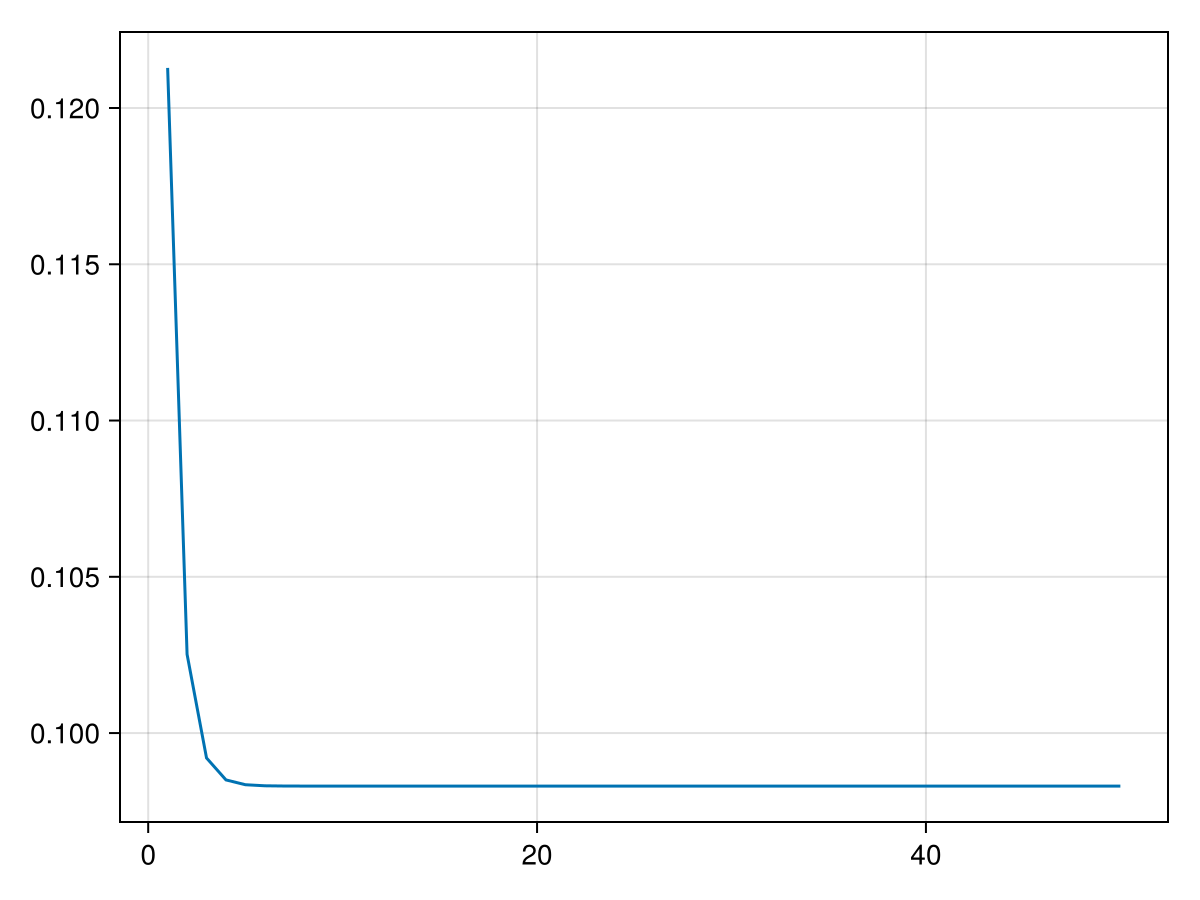

In [17]:
lines(iters)

#### Fitted density

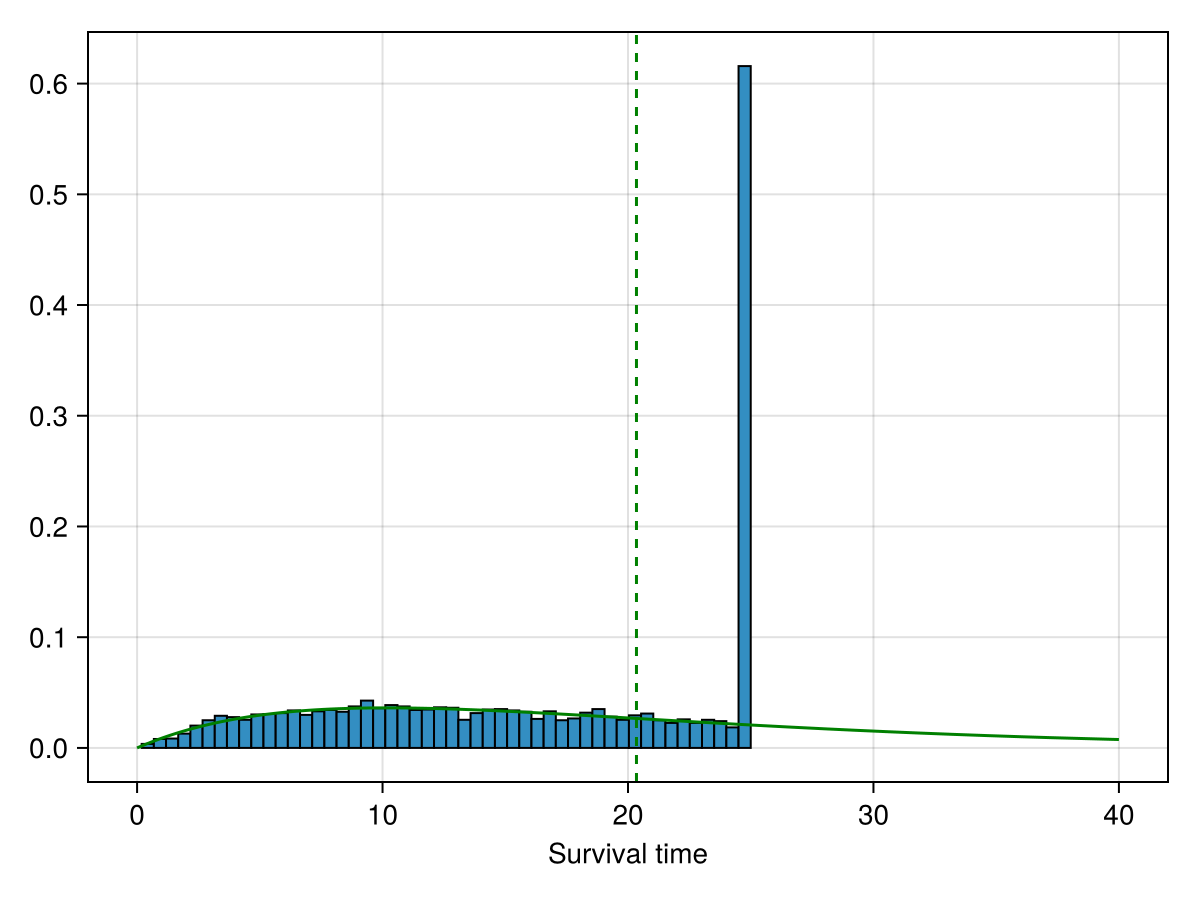

In [18]:
Yest = Gamma(2, 1/θ)
Yinc1 = Gamma(2, 1/(2/mean(y)))
Yinc2 = Gamma(2, 1/(2/mean(y2)))

fig, ax = hist(y, bins = 50, strokewidth = 1, normalization = :pdf,
    label = "Empirical observations", axis = axis_args)
lines!(0..40, x -> pdf(Yest, x), color = :green, label = "Estimated mean density")
vlines!([mean(Yest)], color = :green, linestyle = :dash)
fig

fig, ax = hist(y, bins = 50, strokewidth = 1, normalization = :pdf,
    label = "Empirical observations", axis = axis_args)

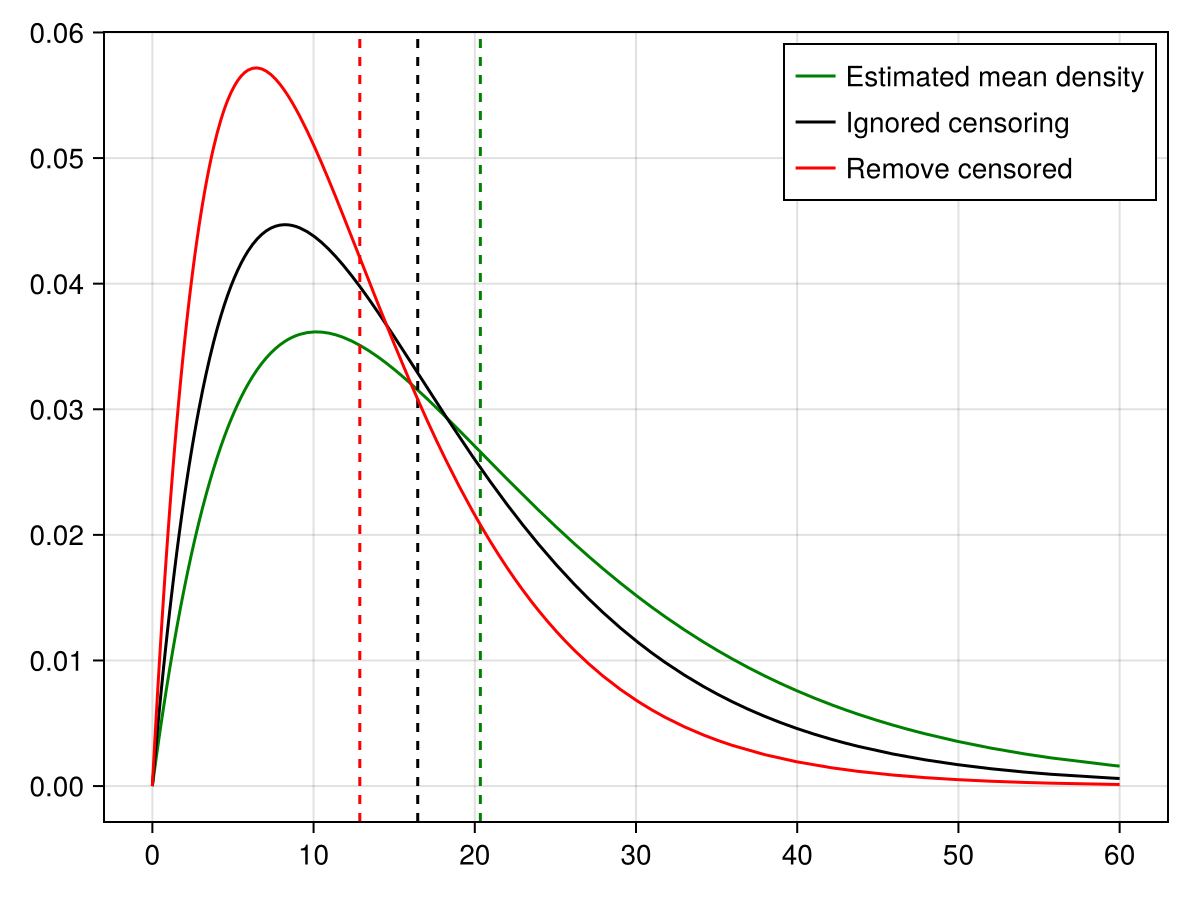

In [19]:
fig, ax = lines(0..60, x -> pdf(Yest, x), color = :green, label = "Estimated mean density")
vlines!([mean(Yest)], color = :green, linestyle = :dash)
lines!(0..60, x -> pdf(Yinc1, x), color = :black, label = "Ignored censoring")
vlines!([mean(Yinc1)], color = :black, linestyle = :dash)
lines!(0..60, x -> pdf(Yinc2, x), color = :red, label = "Remove censored")
vlines!([mean(Yinc2)], color = :red, linestyle = :dash)
axislegend(ax, position = :rt)
fig

## Censored data

In [20]:
using DataFrames
using Distributions
using CairoMakie
using StatsBase

### Simulation

In [21]:
λ = 3
a = 5
Y = Poisson(λ)

Distributions.Poisson{Float64}(λ=3.0)

In [22]:
y = rand(Y, 5000)
y = @. ifelse(y >= a, a, y)

5000-element Vector{Int64}:
 3
 4
 2
 2
 4
 2
 4
 3
 3
 5
 ⋮
 3
 3
 2
 3
 3
 5
 3
 3
 2

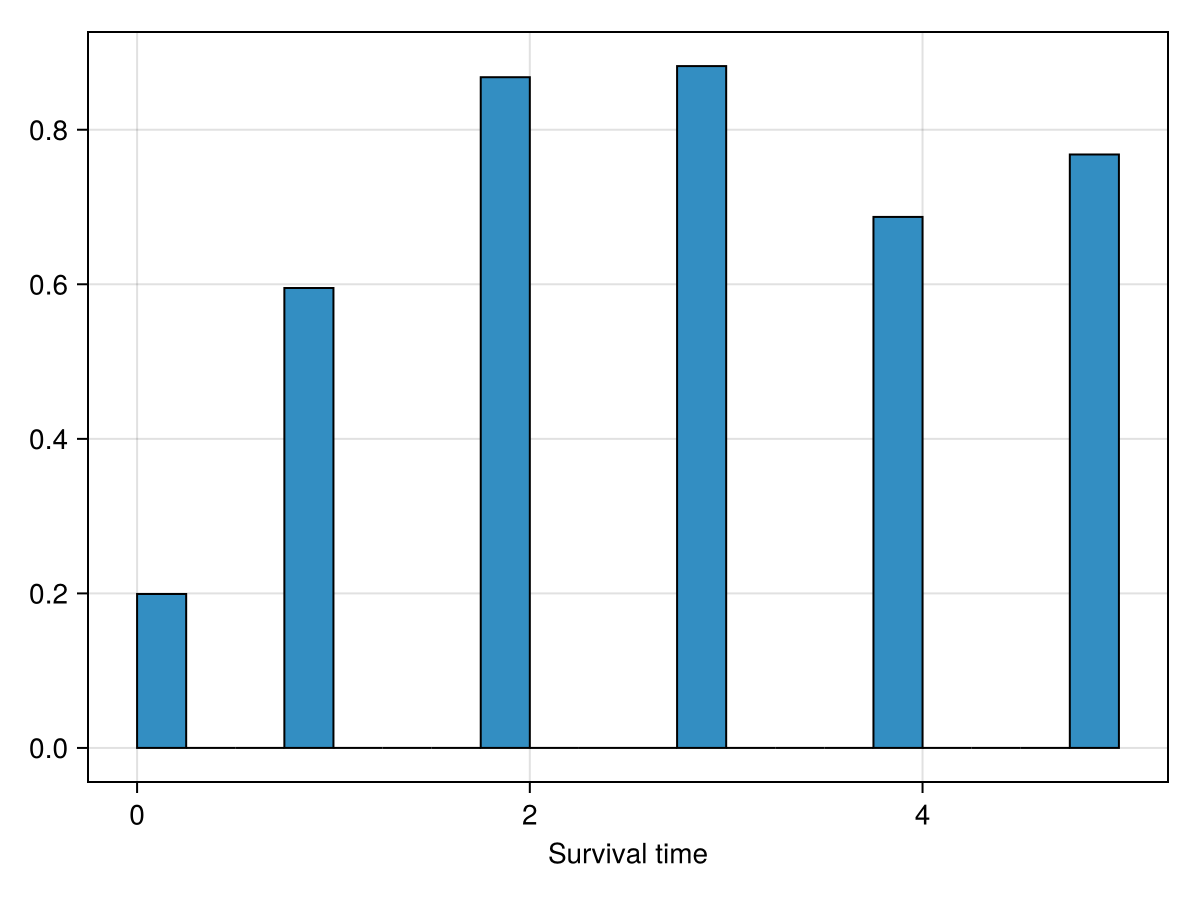

In [23]:
axis_args = (;xlabel = "Survival time")
hist(y, bins = 20, strokewidth = 1, normalization = :pdf, axis = axis_args)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*